# PCA-tSNE-AE

In [2]:
%matplotlib notebook

import tensorflow as tf
import math
from sklearn import datasets
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [3]:
iris_dataset = datasets.load_iris()

## PCA

In [4]:
class TF_PCA:

    def __init__(self, data, target=None, dtype=tf.float32):
        self.data = data
        self.target = target
        self.dtype = dtype

        self.graph = None
        self.X = None
        self.u = None
        self.singular_values = None
        self.sigma = None

    def fit(self):
        self.graph = tf.Graph()
        with self.graph.as_default():
            self.X = tf.placeholder(self.dtype, shape=self.data.shape)

            # Perform SVD
            singular_values, u, _ = tf.svd(self.X)

            # Create sigma matrix
            sigma = tf.diag(singular_values)

        with tf.Session(graph=self.graph) as session:
            self.u, self.singular_values, self.sigma = session.run([u, singular_values, sigma],
                                                                   feed_dict={self.X: self.data})

    def reduce(self, n_dimensions=None, keep_info=None):
        if keep_info:
            # Normalize singular values
            normalized_singular_values = self.singular_values / sum(self.singular_values)

            # Create the aggregated ladder of kept information per dimension
            ladder = np.cumsum(normalized_singular_values)

            # Get the first index which is above the given information threshold
            index = next(idx for idx, value in enumerate(ladder) if value >= keep_info) + 1
            n_dimensions = index

        with self.graph.as_default():
            # Cut out the relevant part from sigma
            sigma = tf.slice(self.sigma, [0, 0], [self.data.shape[1], n_dimensions])

            # PCA
            pca = tf.matmul(self.u, sigma)

        with tf.Session(graph=self.graph) as session:
            return session.run(pca, feed_dict={self.X: self.data})

<IPython.core.display.Javascript object>


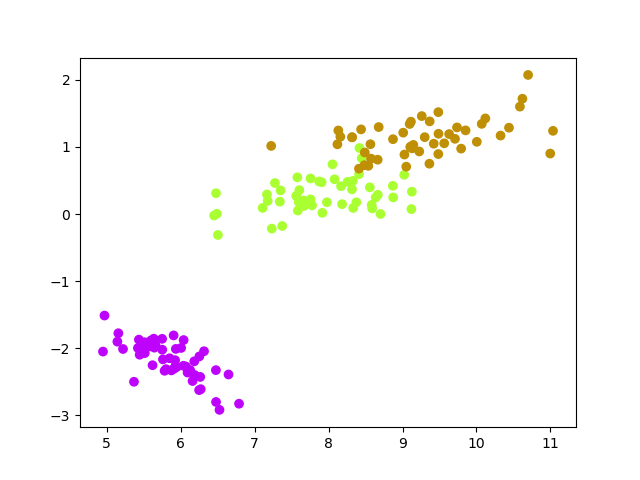

In [14]:
tf_pca = TF_PCA(iris_dataset.data, iris_dataset.target)
tf_pca.fit()
pca = tf_pca.reduce(keep_info=0.9)  # Results in two dimensions

color_mapping = {0: sns.xkcd_rgb['bright purple'], 1: sns.xkcd_rgb['lime'], 2: sns.xkcd_rgb['ochre']}
colors = list(map(lambda x: color_mapping[x], iris_dataset.target))

plt.scatter(pca[:, 0], pca[:, 1], c=colors)

plt.show()

## TSNE

<IPython.core.display.Javascript object>


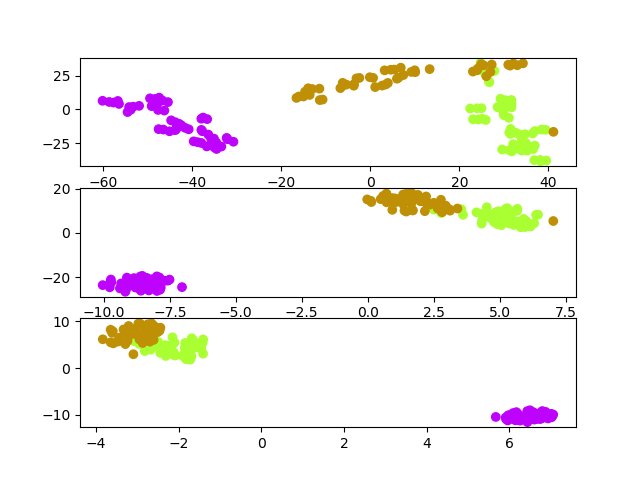

In [16]:
plt.close()

model = TSNE(learning_rate=100, n_components=2, random_state=0, perplexity=5)
tsne5 = model.fit_transform(iris_dataset.data)

model = TSNE(learning_rate=100, n_components=2, random_state=0, perplexity=30)
tsne30 = model.fit_transform(iris_dataset.data)

model = TSNE(learning_rate=100, n_components=2, random_state=0, perplexity=50)
tsne50 = model.fit_transform(iris_dataset.data)

plt.figure(1)
plt.subplot(311)
plt.scatter(tsne5[:, 0], tsne5[:, 1], c=colors)

plt.subplot(312)
plt.scatter(tsne30[:, 0], tsne30[:, 1], c=colors)

plt.subplot(313)
plt.scatter(tsne50[:, 0], tsne50[:, 1], c=colors)

plt.show()

## Auto Encoder

In [23]:
plt.close()

def batch_generator(features, batch_size=50, n_epochs=1000):
    """
    Batch generator for the iris dataset
    """

    # Generate batches
    for epoch in range(n_epochs):
        start_index = 0
        while start_index != -1:
            # Calculate the end index of the batch to generate
            end_index = start_index + batch_size if start_index + batch_size < n else -1

            yield features[start_index:end_index]

            start_index = end_index


# Auto Encoder
class TF_AutoEncoder:
    def __init__(self, features, labels, dtype=tf.float32):
        self.features = features
        self.labels = labels
        self.dtype = dtype

        self.encoder = dict()

    def fit(self, n_dimensions):
        graph = tf.Graph()
        with graph.as_default():

            # Input variable
            X = tf.placeholder(self.dtype, shape=(None, self.features.shape[1]))

            # Network variables
            encoder_weights = tf.Variable(tf.random_normal(shape=(self.features.shape[1], n_dimensions)))
            encoder_bias = tf.Variable(tf.zeros(shape=[n_dimensions]))

            decoder_weights = tf.Variable(tf.random_normal(shape=(n_dimensions, self.features.shape[1])))
            decoder_bias = tf.Variable(tf.zeros(shape=[self.features.shape[1]]))

            # Encoder part
            encoding = tf.nn.sigmoid(tf.add(tf.matmul(X, encoder_weights), encoder_bias))

            # Decoder part
            predicted_x = tf.nn.sigmoid(tf.add(tf.matmul(encoding, decoder_weights), decoder_bias))

            # Define the cost function and optimizer to minimize squared error
            cost = tf.reduce_mean(tf.pow(tf.subtract(predicted_x, X), 2))
            optimizer = tf.train.AdamOptimizer().minimize(cost)

        with tf.Session(graph=graph) as session:
            # Initialize global variables
            session.run(tf.global_variables_initializer())

            for batch_x in batch_generator(self.features):
                self.encoder['weights'], self.encoder['bias'], _ = session.run([encoder_weights, encoder_bias, optimizer],
                                                                            feed_dict={X: batch_x})

    def reduce(self):
        return np.add(np.matmul(self.features, self.encoder['weights']), self.encoder['bias'])

<IPython.core.display.Javascript object>


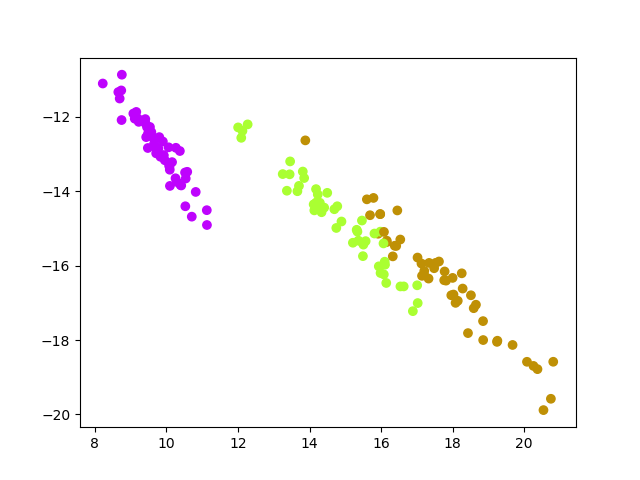

In [22]:
# Mix the data before training
n = len(iris_dataset.data)
random_idx = np.random.permutation(n)
features, labels = iris_dataset.data[random_idx], iris_dataset.target[random_idx]

# Create an instance and encode
tf_ae = TF_AutoEncoder(features, labels)

tf_ae.fit(n_dimensions=2)

auto_encoded = tf_ae.reduce()

colors = list(map(lambda x: color_mapping[x], labels))

plt.scatter(auto_encoded[:, 0], auto_encoded[:, 1], c=colors)

plt.show()